# Clustering Insomnia Patterns by Data From Wearable Devices: Algorithm Development and Validation Study

## - Tensorflow Implementation

In [15]:
import csv
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import stats
from models import *

# Data Preprocessing

In [12]:
raw_data = np.genfromtxt("data/Data.csv", delimiter=',')
index = raw_data[1:, 0:1]
value = np.concatenate((index, raw_data[1:, 3:]), axis=1) 

X = []
for userid in np.unique(index):
    user_data = value[np.where(value[:, 0] == userid)][:, 1:]
    X.append(user_data)
    
new_X = np.array(X).reshape(-1, 14)
new_X = new_X[np.all(new_X != -1, axis = 1)]
minval = np.min(new_X, axis = 0)[None, :]
diff = new_X.max(axis = 0) - new_X.min(axis = 0)[None, :]

Sliding_X = []
column_size = 8
for user_X in X:
    i = 0
    while i + column_size <= user_X.shape[0]:
        Sliding_X.append(user_X[i:i+column_size, :])
        i = i + 1

Preprocessed_X = []
for window in Sliding_X:
    nonzero_data = window[~np.isnan(window).any(axis = 1)]
    nonzero_data = nonzero_data[np.all(nonzero_data != -1, axis = 1)]
    
    if nonzero_data.shape[0] == 0:
        mean = prev_mean
    else:
        mean = np.mean(nonzero_data, axis = 0)[None, :]
        prev_mean = mean
    
    userX = np.array([])
    first = True
    for row in window:
        row = row.reshape(-1, len(row)) 
        if np.any(row[0, :] == -1, axis = 0):               
            minus_index = np.argwhere(row == -1)
            row[0, minus_index] = mean[0, minus_index]
            row = (row - minval) / diff
            if first:
                first = False
                userX = row
                continue

            userX = np.concatenate((userX, row), axis = 0)      
        else:
            row = (row - minval) / diff
            if first:
                first = False
                userX = row
                continue

            userX = np.concatenate((userX, row), axis = 0)
            
    Preprocessed_X.append(userX)  
    
Sliding_X = np.array(Preprocessed_X)
Sliding_X = Sliding_X.reshape(-1, 8, 14, 1)

# Convolutional Autoencoder

In [16]:
class RevisedConvolutionalAutoencoder(object):
    def __init__(self, filter_size, filter_num, encoded_size):
        x = tf.placeholder(tf.float32, shape=[None, 8, 14, 1]) 

        # encoder part
        conv1 = Convolution2D([filter_size, 14, 1, filter_num], padding='VALID', activation=tf.nn.relu, scope='conv_1')(x)
        unfold = Unfold(scope='unfold')(conv1)
        encoded = FullyConnected(encoded_size, activation=tf.nn.relu, scope='encode')(unfold)
        
        # decoder part
        decoded = FullyConnected((8 - filter_size + 1) * 1 * filter_num, activation=tf.nn.relu, scope='decode')(encoded)
        fold = Fold([-1, (8 - filter_size + 1), 1, filter_num], scope='fold')(decoded)
        reconstruction = DeConvolution2D([filter_size, 14, 1, filter_num], 
                                         padding='VALID', 
                                         output_shape=tf.shape(x), 
                                         activation=tf.nn.sigmoid, scope='deconv_2')(fold)

        # loss function
        loss = tf.nn.l2_loss(x - reconstruction)

        # training
        training = tf.train.AdamOptimizer(1e-4).minimize(loss)

        self.x = x
        self.reconstruction = reconstruction
        self.encoded = encoded
        self.loss = loss
        self.training = training
        self.name = "CAE-fs{}-fn{}-es{}".format(filter_size, filter_num, encoded_size)
        
        
    def train(self, data, batch_size, passes, need_print = True):
        with tf.Session() as sess:
            saver = Model.start_new_session(sess)

            # start training
            for step in range(1, 1 + passes):
                for batch_i in range(data.shape[0] // batch_size):
                    train = data[batch_i * batch_size : (batch_i + 1) * batch_size, :, :]
                    self.training.run(feed_dict={self.x: train})
                
                if (need_print and step % 200 == 0) or step == passes:
                    loss = self.loss.eval(feed_dict={self.x: train})
                    print("pass {}, training loss {}".format(step, loss))

                if step == passes:  # save weights
                    saver.save(sess, 'saver/{}'.format(self.name))
                

    def reconstruct(self, data, pid, save = False):
        def weights_to_grid(weights, rows, cols):
            height, width, in_channel, out_channel = weights.shape
            padded = np.pad(weights, [(1, 1), (1, 1), (0, 0), (0, rows * cols - out_channel)], 
                            mode='constant', constant_values=0)
            transposed = padded.transpose((3, 1, 0, 2))
            reshaped = transposed.reshape((rows, -1))
            grid_rows = [row.reshape((-1, height + 2, in_channel)).transpose((1, 0, 2)) for row in reshaped]
            grid = np.concatenate(grid_rows, axis=0)

            return grid.squeeze()

        with tf.Session() as sess:
            saver, model_name = Model.get_particular_session(sess, self.name)
                        
            # visualize results
            batch_size = 35
            x = data[(batch_size * pid):(batch_size * (pid + 1)), :, :, :]
            org, recon = sess.run((self.x, self.reconstruction), feed_dict={self.x: x})

            input_images = weights_to_grid(org.transpose((1, 2, 3, 0)), 5, 7)
            recon_images = weights_to_grid(recon.transpose((1, 2, 3, 0)), 5, 7)

            fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(50, 25))
            ax0.imshow(input_images, cmap=plt.cm.gray, interpolation='nearest')
            ax0.set_title('input images', fontsize=40)
            ax1.imshow(recon_images, cmap=plt.cm.gray, interpolation='nearest')
            ax1.set_title('reconstructed images', fontsize=40)
            
            ax0.set_yticklabels([])
            ax0.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_xticklabels([])        
            
            if save:
                plt.savefig('results/{}_reconstructed.png'.format(self.name), bbox_inches='tight')
            else:
                plt.show()
            
    def getLatentVariable(self, data):
        with tf.Session() as sess:
            saver, model_name = Model.get_particular_session(sess, self.name)
            org, encoded = sess.run((self.x, self.encoded), feed_dict={self.x: data})
            
        return encoded  

# Hyperparameters

In [20]:
encoded_size = 15
filter_size = 3
filter_num = 30
decay_weight = 0.75
batchsize = 35
epoch_pass = 20000

# Sliding window with weight decaying

In [18]:
Sliding_Decayed_X = []
for window in Sliding_X:
    row_count = 7
    new_window = []
    for k in range(8):
        new_window.append(window[k, :, :] * (decay_weight ** row_count))
        row_count -= 1
    Sliding_Decayed_X.append(new_window)  
Sliding_Decayed_X = np.array(Sliding_Decayed_X)

# Training

In [22]:
print("Start Training {}-{}-{}".format(filter_size, filter_num, encoded_size))
conv_autoencoder = RevisedConvolutionalAutoencoder(filter_size, filter_num, encoded_size)
conv_autoencoder.name = conv_autoencoder.name + "decay_weight_{}".format(str(int(decay_weight * 100)))
conv_autoencoder.train(Sliding_Decayed_X, batch_size = batchsize, passes = epoch_pass)

Start Training 3-30-15
started a new session
pass 200, training loss 5.835641860961914
pass 400, training loss 4.639789581298828
pass 600, training loss 3.3636629581451416
pass 800, training loss 2.6117470264434814
pass 1000, training loss 2.441309690475464
pass 1200, training loss 2.368809938430786
pass 1400, training loss 2.298414945602417
pass 1600, training loss 2.2253313064575195
pass 1800, training loss 2.1519758701324463
pass 2000, training loss 2.087514877319336
pass 2200, training loss 2.046187400817871
pass 2400, training loss 1.9711220264434814
pass 2600, training loss 1.9473698139190674
pass 2800, training loss 1.926649570465088
pass 3000, training loss 1.9067797660827637
pass 3200, training loss 1.8865101337432861
pass 3400, training loss 1.864320993423462
pass 3600, training loss 1.8418536186218262
pass 3800, training loss 1.8229140043258667
pass 4000, training loss 1.8093599081039429
pass 4200, training loss 1.7965102195739746
pass 4400, training loss 1.7824771404266357


# Save

In [23]:
latent = conv_autoencoder.getLatentVariable(Sliding_Decayed_X)
np.savetxt('results/{}_latent.csv'.format(conv_autoencoder.name), latent, delimiter=",")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from saver/CAE-fs3-fn30-es15decay_weight_75
restored model: CAE-fs3-fn30-es15decay_weight_75


# Visualization (example)

user id = 4
INFO:tensorflow:Restoring parameters from saver/CAE-fs3-fn30-es15decay_weight_75
restored model: CAE-fs3-fn30-es15decay_weight_75


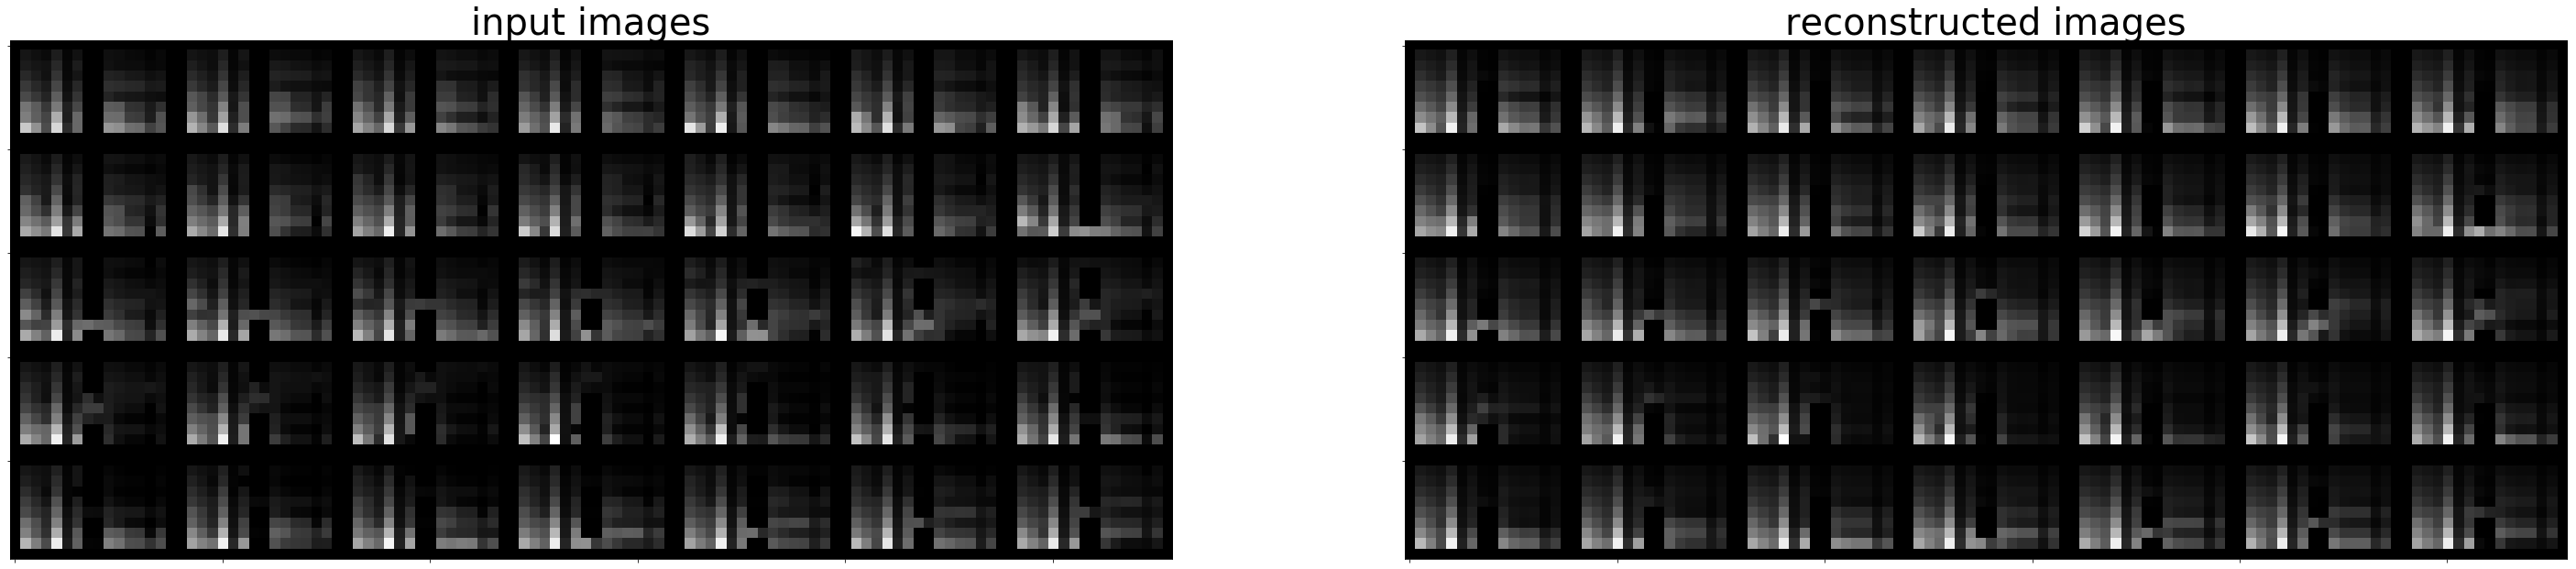

user id = 5
INFO:tensorflow:Restoring parameters from saver/CAE-fs3-fn30-es15decay_weight_75
restored model: CAE-fs3-fn30-es15decay_weight_75


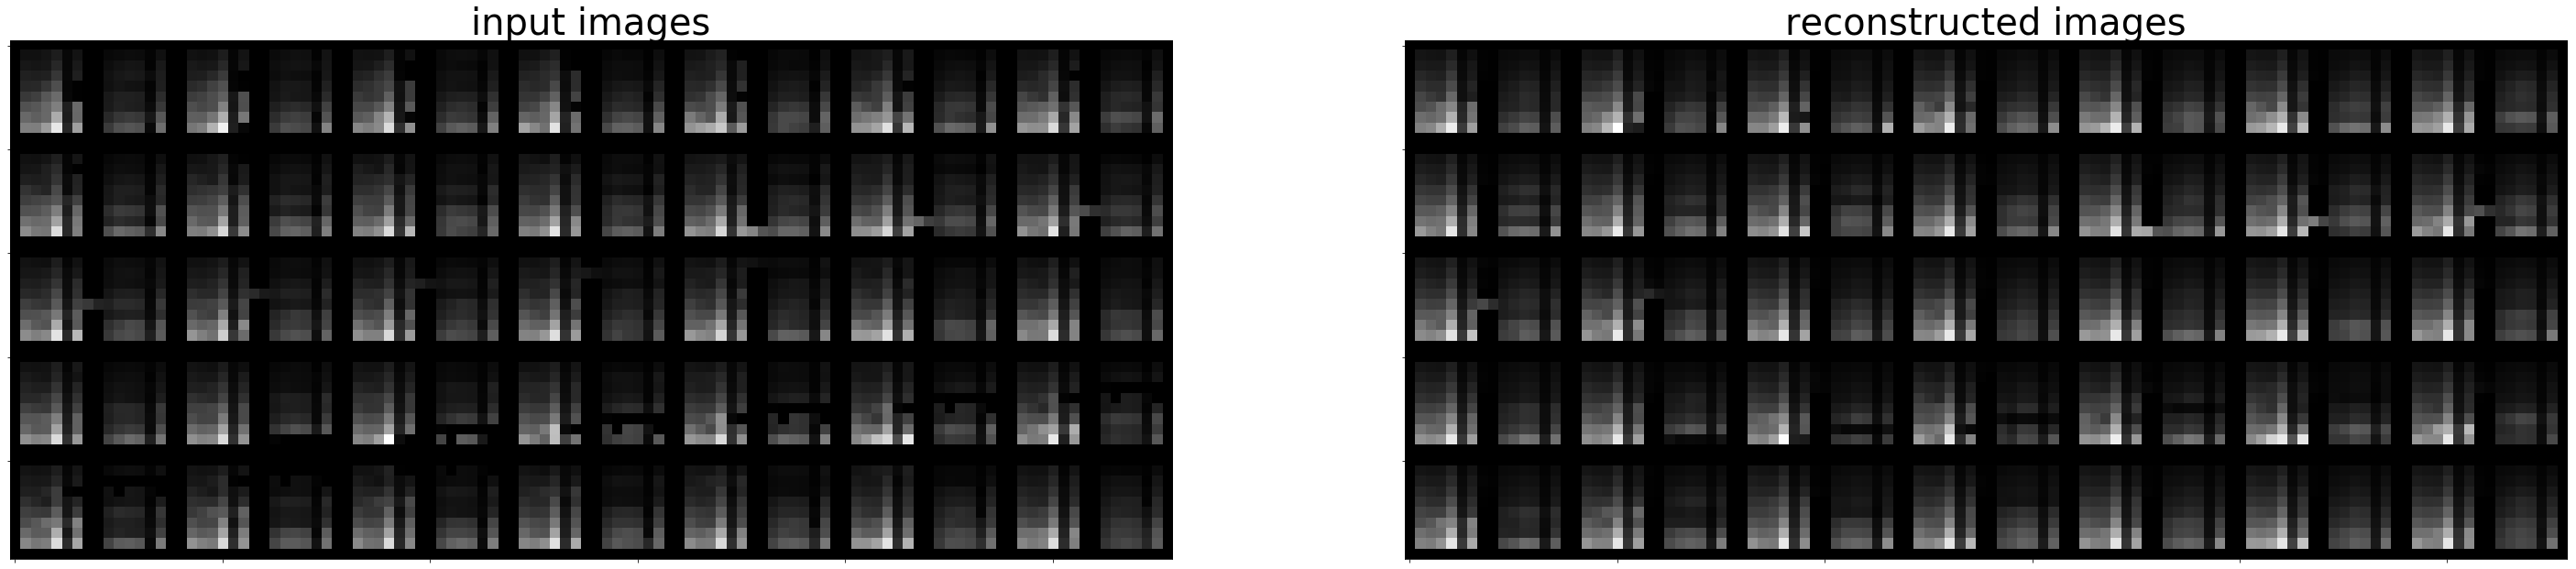

user id = 6
INFO:tensorflow:Restoring parameters from saver/CAE-fs3-fn30-es15decay_weight_75
restored model: CAE-fs3-fn30-es15decay_weight_75


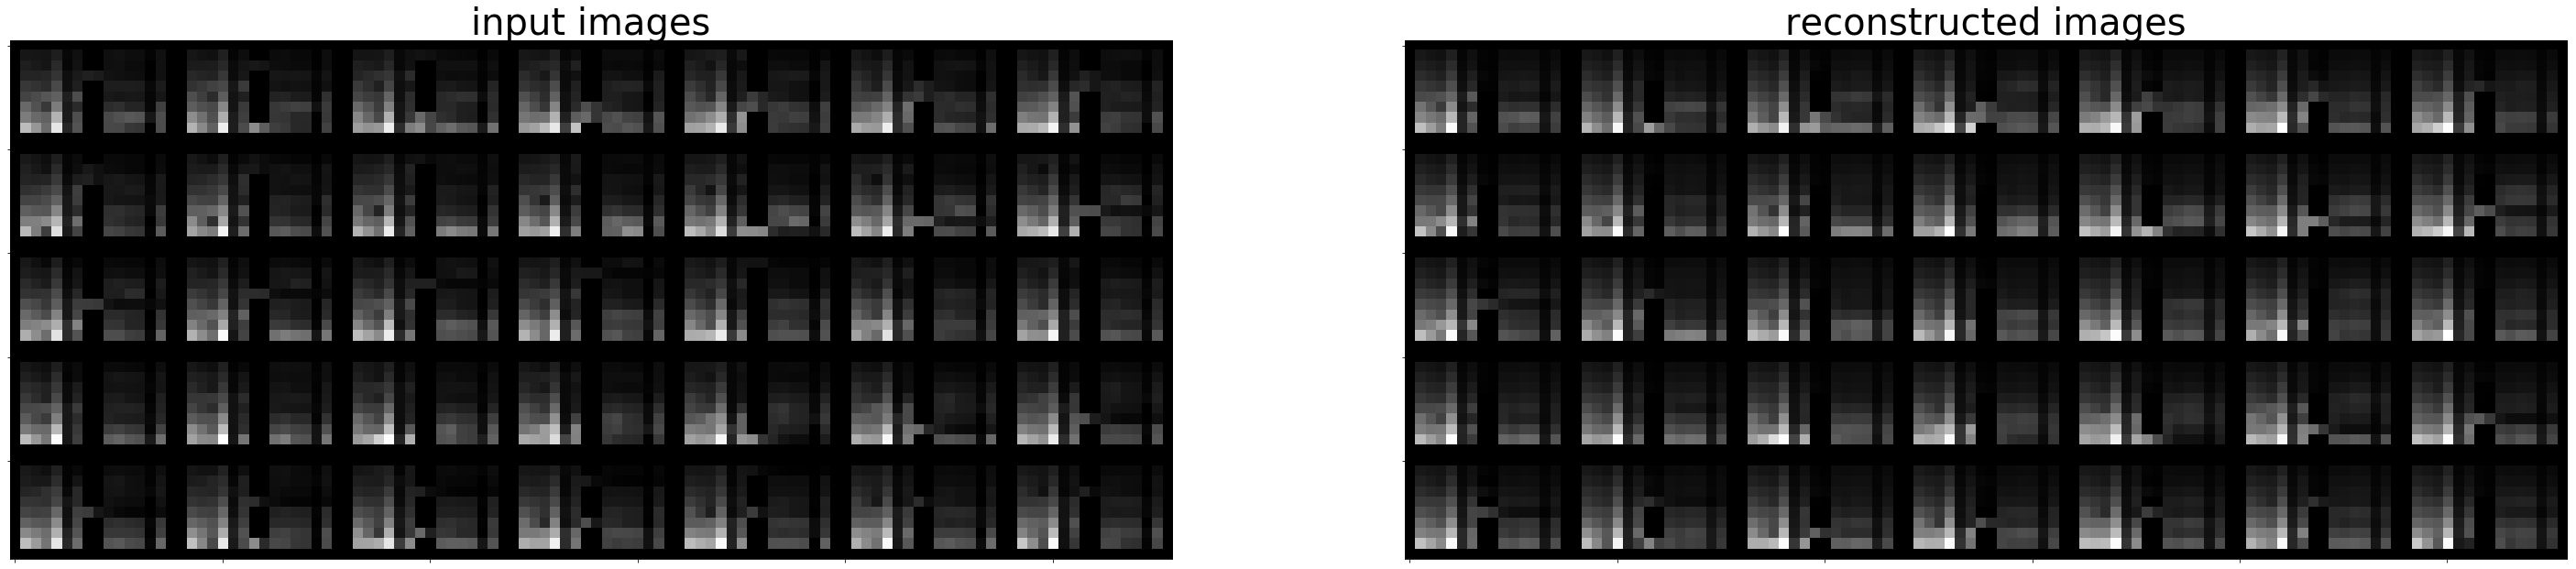

In [26]:
for i in range(4, 7):
    print("user id = {}".format(str(i)))
    conv_autoencoder.reconstruct(Sliding_Decayed_X, i, save = False)